<center><h1>Udacity OSM Project - Irvine, CA - Randy Crane</h1></center>

<h1>Introduction</h1>

In this project I will be exploring OpenStreetMap data for Irvine, California. I chose this map data because Irvine is my current city of residence. I am already pretty familiar with the area, which will potentially help me recognize some of the bad data in the set. At the same time, I'm curious about some aspects of my city and I will use this data set to glean some new insights about it.

The data consists of XML elements called "nodes" (points of interest) and "ways" (linear features and area boundaries). Each element can have one or more tags associated with it. These tags provide more details and information about the element.  Additional information about the data structure can be found here: https://wiki.openstreetmap.org/wiki/OSM_XML

I will first explore the raw XML data using Python and audit tags that are appear to have errors, and tags that I'm interested in analyzing in more detail. Due to the scope of this project, I will not be cleaning every error I find, but will focus on two or three to meet the requirements of the project. After identifying and cleaning the problem areas, I will export the data to CSV files, then import it into a SQLite database. Finally, I will query the database to gain greater insights.



<h1>Map Area</h1>

On OpenStreetMap.org, the area I selected to include as much of Irvine I could without too much data from other cities is bounded within the following coordinates:

Longitude: -117.8792, -117.7281
</p>
Latitude: 33.7301, 33.6135


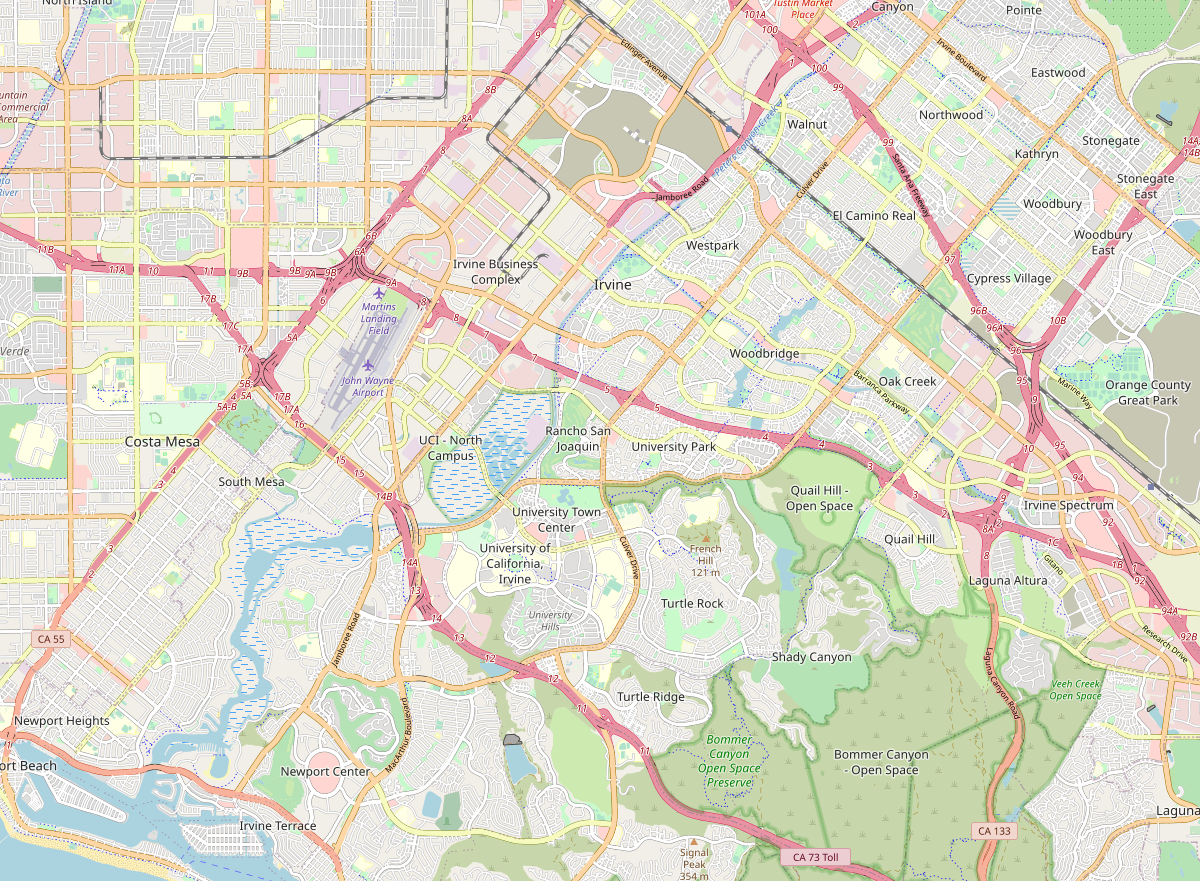


The map can be found here: https://www.openstreetmap.org/search?query=Irvine%2C%20CA#map=12/33.7299/-117.8232. 

The underlying data was downloaded using the Overpass API, at this link: https://overpass-api.de/api/map?bbox=-117.8792,33.6135,-117.7281,33.7301.

In [1]:
import os
os.getcwd()

'C:\\Users\\randy'

In [2]:
os.chdir("D:\Documents\School - WGU\Term 4\C750\Project")
os.getcwd()

'D:\\Documents\\School - WGU\\Term 4\\C750\\Project'

<h1>Data Exploration and Cleaning</h1>

Using the 'OSM_sampling.py' script provided by Udacity, I will create a sample file of every 10th element from the original file map data.

In [3]:
#Importing modules
import xml.etree.ElementTree as ET
from collections import defaultdict
import re
import pprint
import re
import xml.etree.cElementTree as ET

In [4]:
#Import osm file and create sample dataset

#!/usr/bin/env python
# -*- coding: utf-8 -*-

OSM_FILE = "map.osm"
SAMPLE_FILE = "sample.osm"

k = 10 # Parameter: take every k-th top level element

def get_element(osm_file, tags=('node', 'way', 'relation')):
    context = iter(ET.iterparse(osm_file, events=('start', 'end')))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

            
with open(SAMPLE_FILE, 'w', encoding='utf8') as output:
    output.write('<?xml version="1.0" encoding="UTF-8"?>\n')
    output.write('<osm>\n  ')
    # Write every kth top level element
    for i, element in enumerate(get_element(OSM_FILE)):
        if i % k == 0:
            output.write(ET.tostring(element, encoding='unicode'))
    output.write('</osm>')

Next, we will parse the sample dataset to count the unique element types. 

In [5]:
def count_tags(filename):
    tags = {}
    for event, elem in ET.iterparse(filename, events=('start', )):
        if elem.tag not in tags:
            tags[elem.tag] = 1
        else:
            tags[elem.tag] += 1
    return tags

def test():

    tags = count_tags('sample.osm')
    pprint.pprint(tags)
    

if __name__ == "__main__":
    test()

{'member': 2608,
 'nd': 38943,
 'node': 33409,
 'osm': 1,
 'relation': 145,
 'tag': 35851,
 'way': 4695}


By using the count_tags function, I got the number of unique tags shown. The ones that I expect to be of the most interest to me are:

<ul>
    <li>Nodes</li>
    <li>Tags</li>
    <li>Ways</li>
    <li>Members</li>
</ul>


To begin, I will check the "k" value for each "<tag>" to see if there are any potential problems. There are three regular expressions: 
    
<ol>
    <li>"lower", for tags that contain only lowercase letters and are valid,</li>
    <li>"lower_colon", for otherwise valid tags with a colon in their names,</li>
    <li>"problemchars", for tags with problematic characters, and</li>
    <li>"other", for other tags that do not fall into the other three categories.</li>
</ol>
    
We need a count of each of these four tag categories in a dictionary.

In [6]:
lower = re.compile(r'^([a-z]|_)*$')
lower_colon = re.compile(r'^([a-z]|_)*:([a-z]|_)*$')
problemchars = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')


def key_type(element, keys):
    if element.tag == "tag":
        if lower.search(element.attrib['k']):
            keys['lower'] +=1
        elif lower_colon.search(element.attrib['k']):
            keys['lower_colon']+=1
        elif problemchars.search(element.attrib['k']):
            keys['problemchars']+=1
        else:
            keys['other']+=1
        
    return keys



def process_map(filename):
    keys = {"lower": 0, "lower_colon": 0, "problemchars": 0, "other": 0}
    for _, element in ET.iterparse(filename):
        keys = key_type(element, keys)

    return keys



def test():
    keys = process_map('sample.osm')
    pprint.pprint(keys)

if __name__ == "__main__":
    test()

{'lower': 17335, 'lower_colon': 18152, 'other': 364, 'problemchars': 0}


As we continue to explore the data, let's find out how many unique users have contributed to the data in this area.

In [7]:
def get_user(element):
    return


def process_map(filename):
    users = set()
    for _, element in ET.iterparse(filename):
        try:
            users.add(element.attrib['uid'])
        except KeyError:
            continue

    return users


def test():

    users = process_map('sample.osm')
    pprint.pprint(len(users))

if __name__ == "__main__":
    test()

769


Now, we need to check the validity and consistency of the street names.

I know from personal experience that these will be a challenge and result in a long list of streets outside the "expected" values. Many streets in Irvine consist of names that do not have street suffixes. Thus, I would expect to see names like Cardiff, Apache, Lexington, and Paseo Westpark.

In [8]:
%%capture

#The resulting output from this frame would be very, very long, so I am supressing it for the sake of the final report.
#However, the extracted code files will have it without this supression.

OSMFILE = "sample.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road",
            "Trail", "Parkway", "Plaza", "Park"]


def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)

def print_sorted_dic(d):
    keys = d.keys()
    keys = sorted(keys, key=lambda s: s.lower())
    for k in keys:
        v = d[k]
        print("%s: %d" % (k, v))

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit():
#    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(OSMFILE, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    pprint.pprint(dict(street_types))

if __name__ == '__main__':
    audit()

The street name data is remarkably clean, though not perfect. Let's clean it up.

In [9]:
mapping = {"St": "Street",
           "ST": "Street",
           "St.": "Street",
           "St,": "Street",
           "Street.": "Street",
           "street": "Street",
           "Sq": "Square",
           "Rd.": "Road",
           "Rd": "Road",
           "Ave": "Avenue",
           "DR.": "Drive"
           }

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)


def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")


def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osmfile, events=("start",)):

        if elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types


def update_name(name, mapping):
    for key, value in mapping.items():
        if re.search(key, name):
            name = re.sub(street_type_re, value, name)

    return name


def test():
    st_types = audit(OSMFILE)
    for st_type, ways in st_types.items():
        for name in ways:
            better_name = update_name(name, mapping)
            print (name, "=>", better_name)


if __name__ == '__main__':
    test()

Lafayette Way => Lafayette Way
Carrington Way => Carrington Way
Mayfield Way => Mayfield Way
Scientific Way => Scientific Way
Fairfax Way => Fairfax Way
Manchester Way => Manchester Way
Sandburg Way => Sandburg Way
Wheaton Way => Wheaton Way
Camden Way => Camden Way
Byron Way => Byron Way
6685 Marina Way => 6685 Marina Way
Taylor Way => Taylor Way
Wesley Way => Wesley Way
Liberty => Liberty
Honors => Honors
Romano => Romano
Commerce => Commerce
Quail Ridge => Quail Ridge
Visions => Visions
Roosevelt => Roosevelt
Theory => Theory
Amistad => Amistad
Peters Canyon => Peters Canyon
Silk Tree => Silk Tree
Knollcrest => Knollcrest
Rockefeller => Rockefeller
Enclave Circle => Enclave Circle
Gateway Circle => Gateway Circle
Grandoaks Circle => Grandoaks Circle
Munton Circle => Munton Circle
Danberry Circle => Danberry Circle
Dartmouth Circle => Dartmouth Circle
Kimberly Circle => Kimberly Circle
Bunsen => Bunsen
Parkway Loop => Parkway Loop
Vintage => Vintage
Payton => Payton
Roycroft => Roycr

This is better, though it does introduce a new problem: names that start with "St" (e.g. "Stanza") are changed to "Street," which is obviously not what was intended. If this project's purpose was to fully clean the data 100%, I would add code to exclude those those exceptions. However, as a proof of concept for the methodology this was successful, so we will move on. 

Let's look at the zip codes in the dataset.

In [10]:
# Here we create a dictionary of our postal codes
def audit_postal_code(postal_code_types, postal_code):  
    if not postal_code.isupper() or ' ' not in postal_code:
        postal_code_types['Postal Codes'].add(postal_code)
    else:
        postal_code_types['other'].add(postal_code)
    return postal_code_types

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode")

def audit(filename):
    f = (filename)
    postal_code_types = defaultdict(set)
    
    for event, element in ET.iterparse(f, events=("start",)):
        if element.tag =="way":
            for tag in element.iter("tag"):
                if is_postal_code(tag):
                    audit_postal_code(postal_code_types, tag.attrib['v'])
    print(dict(postal_code_types))

if __name__ == '__main__':
    audit(OSMFILE)

{'Postal Codes': {'92653', '92714', '92663', '92697', '92617', '92614', '92705', '92637', '92782', '92604', '92612', '92780', '92618', '92707', '92620', '92660', '92603', '92626', '92602', '92606'}}


In [11]:
OSMFILE = "sample.osm"
postal_code_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["92602", "92603", "92604", "92606", "92612", "92614", "92616", "92617", 
            "92618", "92619", "92620", "92623", "92650", "92697"]


def audit_postal_code(postal_code_types, postal_codes):
    m = postal_code_type_re.search(postal_codes)
    if m:
        postal_code = m.group()
        if postal_code not in expected:
            postal_code_types[postal_code].add(postal_code)

def is_postal_code(elem):
    return (elem.attrib['k'] == "addr:postcode")


def audit():
    postal_codes = defaultdict(set)
    for event, elem in ET.iterparse(OSMFILE, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_postal_code(tag):
                    audit_postal_code(postal_codes, tag.attrib['v'])
    
    print("Postal codes in data set that are not in Irvine")
    pprint.pprint(dict(postal_codes))

if __name__ == '__main__':
    audit()

Postal codes in data set that are not in Irvine
{'92520': {'92520'},
 '92625': {'92625'},
 '92626': {'92626'},
 '92630': {'92630'},
 '92637': {'92637'},
 '92653': {'92653'},
 '92657': {'92657'},
 '92660': {'92660'},
 '92663': {'92663'},
 '92705': {'92705'},
 '92707': {'92707'},
 '92714': {'92714'},
 '92780': {'92780'},
 '92782': {'92782'}}


Let's see what unique keys there are, and how many.

In [12]:
%%capture

#The resulting output from this frame would be very, very long, so I am supressing it for the sake of the final report.
#However, the extracted code files will have it without this supression.

def unique_keys(filename):
    distinct_keys=[]
    count=1

    EL=get_element(filename, tags=('node', 'way', 'relation'))
    for element in EL:
        if element.tag=='node' or element.tag=='way':
            for tag in element.iter('tag'):
                if tag.attrib['k'] not in distinct_keys:
                    distinct_keys.append(tag.attrib['k'])
                    count+=1
    distinct_keys.sort()
    print("Total number of unique keys (tag attrib['k'])is {}:".format(count))
    
#    return distinct_keys
    pprint.pprint(distinct_keys)
    
unique_keys(OSMFILE)  # Using Sample file as input to audit the addr:street key

Total number of unique keys (tag attrib['k'])is 324.

There are a few "Fix Me" tags. I won't be cleaning those today, but they definitely indicate a problem with the data set that it would help users of OpenStreetMaps to resolve.

Let's also take a look at phone number formats and state names before we do the analysis and cleaning of the full data set.


In [13]:
def is_phone(elem):
    return (elem.attrib['k'] == "phone" or elem.attrib['k'] == "contact:phone")

def audit_phone_number_formats(phone_number_formats, phone_number):

    # Convert any digit to an 'X' sign (e.g. '(212) 333-3100' becomes '(XXX) XXX-XXXX')
    phone_number_format = re.sub('\d', 'X', phone_number)
    phone_number_formats[phone_number_format] += 1

def audit(osmfile):
    osm_file = OSMFILE
    phone_number_formats = defaultdict(int)
    for event, elem in ET.iterparse(osm_file, events=('start',)):

        if elem.tag == 'node' or elem.tag == 'way':
            for tag in elem.iter('tag'):
                # Audit phone numbers
                if is_phone(tag):
                    audit_phone_number_formats(phone_number_formats, tag.attrib['v'])
    pprint.pprint(dict(phone_number_formats))

audit(OSM_FILE)

{'(XXX) XXX-XXXX': 3,
 '+X (XXX) XXX-XXXX': 2,
 '+X XXX XXX XXXX': 3,
 '+X-XXX-XXX-XXXX': 3,
 'XXX-XXX-XXXX': 2}


In [14]:
def is_state(elem):
    return (elem.attrib['k'] == "addr:state")

state_types = defaultdict(int)

def audit_state(state_types, state_name):
    if state_name != 'CA':
        state_types[state_name] += 1
        print(state_name)

for event, elem in ET.iterparse(OSMFILE, events =("start",)):
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            if is_state(tag):
                audit_state(state_types, tag.attrib['v'])

California
ca
ca


The last step I'm going to take before reshaping the data and exporting it to CSV files is to clean up the street names for the whole data set, not just the same set.

In [15]:
%%capture

#The resulting output from this frame would be very, very long, so I am supressing it for the sake of the final report.
#However, the extracted code files will have it without this supression.

OSMFILE = "map.osm"
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)


expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road",
            "Trail", "Parkway", "Plaza", "Park"]

mapping = {"St": "Street",
           "ST": "Street",
           "St.": "Street",
           "St,": "Street",
           "Street.": "Street",
           "street": "Street",
           "Sq": "Square",
           "Rd.": "Road",
           "Rd": "Road",
           "Ave": "Avenue",
           "DR.": "Drive",
           "Blvd": "Boulevard"
           }

def fix_street(elem):

    street_types = defaultdict(set)
    if elem.tag == "node" or elem.tag == "way":
        for tag in elem.iter("tag"):
            if is_street_name(tag):
                audit_street_type(street_types, tag.attrib['v'])

            for st_type, ways in street_types.items():
                for name in ways:
                    for key,value in mapping.items():
                        n = street_type_re.search(name)
                        if n:
                            street_type = n.group()
                            if street_type not in expected:
                                if street_type in mapping:
                                    better_name = name.replace(key,value)
                                    if better_name != name:
                                        print ("Fixed Street:", tag.attrib['v'], "=>", better_name)
                                        tag.attrib['v'] = better_name
                                        return

                                
fix_street(elem)


In [16]:
def fix_state(elem):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_state(tag):
                    if tag.attrib['v'] != 'CA':
                        print ("Fixed State: ", tag.attrib['v'], "=> 'CA'")
                        tag.attrib['v'] = 'CA'


<h1>Data Reshaping and Exporting to CSV Files</h1>

OK, it's time to actually reshape/clean the data and get it exported to CSV files.

In [17]:
# schema.py

schema = {
    'node': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
            }
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
            }
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    }
}


In [18]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

import csv
import codecs
import pprint
import re
import xml.etree.cElementTree as ET

import cerberus

import schema

OSM_PATH = "map.osm"

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']

print ("Street Names and State Codes Fixed:")
print ("\n")

# Fix Street & State Names                             
def fix_element(elem):
    fix_street(elem)
    fix_state(elem)
                                

def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    tags = []  # Handle secondary tags the same way for both node and way elements

    # Fix data issues, based on auditing results

    fix_element(element)

    # Shape elements, by splitting the attribute fields per the rules described in the
    # Udacity commentary

    if element.tag == 'node':

            for node_field in node_attr_fields:
                node_attribs[node_field] =element.attrib[node_field]

            for tag in element.iter('tag'):
                k = tag.attrib['k']

                # ignores tags containing problem characters in the k tag attribute:

                if re.search(PROBLEMCHARS,k):
                    continue
                else:
                    pass

                tag_dict = {}

                tag_dict['id'] = node_attribs['id']

                colon_find = re.split('[:]', k)

                if len(colon_find) == 1:

                    tag_dict['key'] = k
                    tag_dict['type'] = 'regular'

                elif len(colon_find) == 2:

                    tag_dict['key'] = colon_find[1]
                    tag_dict['type'] = colon_find[0]

                elif len(colon_find) > 2:

                    tag_dict['key'] = ':'.join(colon_find[1:])
                    tag_dict['type'] = colon_find[0]

                tag_dict['value'] = tag.attrib['v']

                tags.append(tag_dict)

            return {'node': node_attribs, 'node_tags': tags}

    elif element.tag == 'way':

        for way_field in way_attr_fields:
            way_attribs[way_field] =element.attrib[way_field]

        for tag in element.iter('tag'):
            k = tag.attrib['k']

            # ignores tags containing problem characters in the k tag attribute:

            if re.search(PROBLEMCHARS,k):
                print ("Problem character found - skipping element")
                continue
            else:
                pass

            tag_dict = {}

            tag_dict['id'] = way_attribs['id']

            colon_find = re.split('[:]', k)

            if len(colon_find) == 1:

                tag_dict['key'] = k
                tag_dict['type'] = 'regular'

            elif len(colon_find) == 2:

                tag_dict['key'] = colon_find[1]
                tag_dict['type'] = colon_find[0]

            elif len(colon_find) > 2:

                tag_dict['key'] = ':'.join(colon_find[1:])
                tag_dict['type'] = colon_find[0]

            tag_dict['value'] = tag.attrib['v']

            tags.append(tag_dict)

        n = 0
        for nd in element.iter('nd'):

            nd_dict = {}

            nd_dict['id'] = way_attribs['id']
            nd_dict['node_id'] = nd.attrib['ref']
            nd_dict['position'] = n
            way_nodes.append(nd_dict)
            n+=1

        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': tags}


        
# ================================================== #
#               Helper Functions                     #
# ================================================== #
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()


def validate_element(element, validator, schema=schema):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.items())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))


class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: v for k, v in row.items()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)


# ================================================== #
#               Main Function                        #
# ================================================== #
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w', 'utf-8') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w', 'utf-8') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w', 'utf-8') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w', 'utf-8') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w', 'utf-8') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)

                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


if __name__ == '__main__':
    # Note: Validation is ~ 10X slower. For the project consider using a small
    # sample of the map when validating.
    process_map(OSM_PATH, validate=False)
    
print("Reshaping and export complete.")


Street Names and State Codes Fixed:


Fixed State:  ca => 'CA'
Fixed State:  California => 'CA'
Fixed Street: MacArthur Blvd => MacArthur Boulevard
Fixed State:  ca => 'CA'
Fixed Street: Morse Ave => Morse Avenue
Fixed Street: S Ritchey St => S Ritchey Street
Fixed State:  ca => 'CA'
Fixed Street: Angelou St => Angelou Street
Fixed Street: Angelou St => Angelou Street
Fixed Street: Angelou St => Angelou Street
Fixed Street: Angelou St => Angelou Street
Fixed Street: Angelou St => Angelou Street
Fixed Street: Angelou St => Angelou Street
Fixed Street: Angelou St => Angelou Street
Fixed Street: Angelou St => Angelou Street
Fixed Street: Angelou St => Angelou Street
Fixed Street: Angelou St => Angelou Street
Fixed Street: Angelou St => Angelou Street
Fixed Street: Turing St => Turing Street
Fixed Street: Turing St => Turing Street
Fixed Street: Turing St => Turing Street
Fixed Street: Turing St => Turing Street
Fixed Street: Turing St => Turing Street
Fixed Street: Turing St => Turing Str

In [19]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)
conn = sqlite3.connect('irvine_osm_database.sqlite')
cursor = conn.cursor()
print("Opened database successfully")

Opened database successfully


In [20]:
#Tables created on first run. Do not need to re-create them every time, so now commenting out the rest of this section.

#def main():
#    database = r"D:\Documents\School - WGU\Term 4\C750\Project\irvine_osm_database.db"
#
#    sql_create_nodes_table = """CREATE TABLE nodes (
#        id INTEGER PRIMARY KEY NOT NULL,
#        lat FLOAT,
#        lon FLOAT,
#        user TEXT,
#        uid INTEGER,
#        version TEXT,
#        changeset INTEGER,
#        timestamp TEXT
#    );"""
#
#    sql_create_nodes_tags_table = """CREATE TABLE IF NOT EXISTS nodes_tags (
#        id INTEGER,
#        key TEXT,
#        value TEXT,
#        type TEXT,
#        FOREIGN KEY (id) REFERENCES nodes(id)
#    );"""
#
#
#     sql_create_ways_table = """CREATE TABLE IF NOT EXISTS ways (
#         id INTEGER PRIMARY KEY NOT NULL,
#         user TEXT,
#         uid INTEGER,
#         version TEXT,
#         changeset INTEGER,
#         timestamp TEXT
#     );"""

#     sql_create_ways_tags_table = """CREATE TABLE IF NOT EXISTS ways_tags (
#         id INTEGER NOT NULL,
#         key TEXT NOT NULL,
#         value TEXT NOT NULL,
#         type TEXT,
#         FOREIGN KEY (id) REFERENCES ways(id)
#     );"""

#     sql_create_ways_nodes_table = """CREATE TABLE ways_nodes (
#         id INTEGER NOT NULL,
#         node_id INTEGER NOT NULL,
#         position INTEGER NOT NULL,
#         FOREIGN KEY (id) REFERENCES ways(id),
#         FOREIGN KEY (node_id) REFERENCES nodes(id)
#     );"""

    
#    # create a database connection
# #    conn = create_connection(irvine_osm_database.db)

#     # create tables
#     if conn is not None:
#         # create nodes table
#         create_table(conn, sql_create_nodes_table)

#         # create nodes tags table
#         create_table(conn, sql_create_nodes_tags_table)
        
#         # create ways table
#         create_table(conn, sql_create_ways_table)

#         # create ways tags table
#         create_table(conn, sql_create_ways_tags_table)

#         # create ways nodes table
#         create_table(conn, sql_create_ways_nodes_table)
        
#     else:
#         print("Error! cannot create the database connection.")
        

        
# if __name__ == '__main__':
#     main()

In [21]:
# This running directly in sqlite works, but the import statements below do not.

# .mode csv
# .import nodes.csv nodes1
# .import ways.csv ways1
# .import nodes_tags.csv nodes_tags1
# .import ways_tags.csv ways_tags1
# .import ways_nodes.csv ways_nodes1
# BEGIN TRANSACTION;
# INSERT INTO nodes SELECT * FROM nodes1;
# INSERT INTO nodes_tags SELECT * FROM nodes_tags1;
# INSERT INTO ways SELECT * FROM ways1;
# INSERT INTO ways_nodes SELECT * FROM ways_nodes1;
# INSERT INTO ways_tags SELECT * FROM ways_tags1;
# DROP table nodes1;
# DROP table nodes_tags1;
# DROP table ways1;
# DROP table ways_nodes1;
# DROP table ways_tags1;
# COMMIT;

<h1>Data Analysis</h1>

<h2>File Sizes</h2>

<table align = "left">
<tr>
    <td>map.osm</td>
        <td>81 MB</td>
    </tr>
<tr>
    <td>irvine_osm_database.db</td>
        <td>101 MB</td>
    </tr>
<tr>
    <td>nodes.csv</td>
        <td>27 MB</td>
    </tr>
<tr>
    <td>nodes_tags.csv</td>
        <td>5 MB</td>
    </tr>
<tr>
    <td>ways.csv</td>
        <td>3 MB</td>
    </tr>
<tr>
    <td>ways_nodes.csv</td>
        <td>9 MB</td>
    </tr>
<tr>
    <td>ways_tags.csv</td>
        <td>6 MB</td>
    </tr>
</table>

<h3>Let's do some analysis of the data.</h3>

In [22]:
"""
Creates labels and percentage labels for matplotlib.pie().'
Authors: Mark Bannister (make_labels), 'unutbu' (make_autopct)
Source: http://stackoverflow.com/questions/6170246/how-do-i-use-matplotlib-autopct
"""

def make_labels(categories,values):
    """Make pie chart labels with category names and values.
    Args:
        categories (list): list of pie chart categories.
        values (list): list of pie chart values.
    Returns:
        labels (list): list of pie chart labels in the format "Category (Value)".
    """
    labels = []
    for i in range(0, len(values)):
        labels.append("{c} ({v})".format(c=categories[i], v=values[i]))
    return labels

def make_autopct(values):
    """Make pie chart autopct labels.
    Args:
        values (list): list of pie chart values.
    Returns:
        my_autopct (function): function to pass to autopct parameter.
    """
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.1f}%'.format(p=pct,v=val)
    return my_autopct

First, we need to import some Python libraries so we can work with the data.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(color_codes=True)

In [24]:
#Create a basic overview of the database stats.

cursor.execute("ANALYZE;")
cursor.execute("SELECT tbl, stat FROM sqlite_stat1;")
rows = cursor.fetchall()
db_stats = pd.DataFrame(rows[::-1], columns=['Table','Number'])
db_stats

,Table,Number
0,nodes_tags,170339
1,ways,46950
2,ways_tags,182972
3,ways_nodes,378505
4,nodes,334088


We have quite a variety in the number of tags within each table, from about 47,000 in ways to over 378,000 in ways_nodes.

How many unique user contributors are there? Let's see ...

In [25]:
#number unique users
cursor.execute("SELECT count(distinct uid) FROM (SELECT uid FROM nodes UNION ALL SELECT uid FROM ways) a;")
results = cursor.fetchall()
pprint.pprint(results)

[(1017,)]


A little over 1,000 contributors. I haven't cpompared to other areas to see this number relative to the same metric in other areas, but this seems like a good number of contributors to me.

Let's find out who the top 10 are.


In [26]:
#top 10 user contributors

cursor.execute("SELECT uid, user, sum(count) as count FROM \
               (SELECT uid, user, count(*) as count FROM nodes GROUP BY uid \
               UNION \
               SELECT uid, user, count(*) as count FROM ways GROUP BY uid) \
               GROUP BY uid \
               ORDER BY count DESC LIMIT 10;")
rows = cursor.fetchall()
users = pd.DataFrame(rows, columns=['User ID', 'User Name', 'Count'])
users

,User ID,User Name,Count
0,2709708,SJFriedl,122169
1,10165657,Fluffy89502,37379
2,53073,Aaron Lidman,19286
3,6123527,d5f40e1632,9592
4,11567017,n76_oc_import,9365
5,101657,ponzu,9058
6,9812385,leandrok,7843
7,6869539,Grayfox88,6703
8,10544027,Avidgolfer,5759
9,6203853,Bill Sellin,5000


Even within this top tier of contributors, there is a clear division. The top 3 are all above 10,000 (well above), while the ones that make up the remainder of the top 10 are below. The top contributor has more than 3 times as many contributions as the second highest, over 122,000.

Now, what are the most common node tags?

In [27]:
#most common node tags
cursor.execute("SELECT key,count(*) FROM nodes_tags \
                GROUP BY 1 \
                ORDER BY count(*) DESC \
                LIMIT 10;")
rows = cursor.fetchall()
node_keys = pd.DataFrame(rows, columns=['Node Tags', 'Count'])
node_keys

,Node Tags,Count
0,city,28553
1,postcode,28513
2,street,28503
3,housenumber,28485
4,building,27278
5,height,8696
6,highway,5092
7,state,1827
8,barrier,1388
9,traffic_signals,1091


Addresses seem to be the most common node tags, and in general they appear to be fairly complete--housenumber, street, city, and postcode all have counts very close to each other, with only 68 separating the most from the fewest. Interestingly, state is left out of many of them, as there are more than 15 times as many address without the state as there are with it. 

Now, what are the most common amenities?

In [28]:
#most common amenities
cursor.execute("SELECT value, sum(count) as count FROM \
               (SELECT value, count(*) as count FROM nodes_tags WHERE key = 'amenity' \
               GROUP BY value \
               UNION \
               SELECT value, count(*) as count FROM ways_tags WHERE key = 'amenity' \
               GROUP BY value) \
               GROUP BY value ORDER BY count desc LIMIT 20;")
rows = cursor.fetchall()
amenities = pd.DataFrame(rows, columns=['Amenity', 'Count'])
amenities

,Amenity,Count
0,parking,727
1,restaurant,165
2,fast_food,110
3,bench,96
4,shelter,75
5,school,70
6,toilets,66
7,bicycle_parking,64
8,drinking_water,53
9,cafe,53


I think this might tell us more about what contributors prioritize than it does about what amenities are most common. Parking is top of mind for many urban dwellers, so perhaps they notice and contribute parking locations. After parking (and well behind it) comes 5 different designations for places to eat (restaurant, fast food, cafe, bbq, and ice cream). We do like our food here in Irvine!

Next, I would like to see what religion appears to be most popular/common. I did not analyze and clean this data, so it is entirely possible that this will not be completely accurate, but it at least gives us initial idea. 

In [29]:
cursor.execute("SELECT nodes_tags.value, COUNT(*) as num FROM nodes_tags \
                            JOIN (SELECT DISTINCT(id) FROM nodes_tags WHERE value='place_of_worship') i \
                            ON nodes_tags.id=i.id \
                            WHERE nodes_tags.key='religion' \
                            GROUP BY nodes_tags.value \
                            ORDER BY num DESC\
                            LIMIT 1;")
results = cursor.fetchall()
pprint.pprint(results)

[('christian', 7)]


On the surface, it appears that Christian is the most popular religion. However, I ran this code again (not included here) with a slight alteration--I changed the limit from 1 to 3. The result was exactly the same, which means there are no other religions identified by the religion tag. This seems extraordinarily unlikely, so some additional data cleaning would need to be done on this tag before running it again to provide any meaningful result.

One thing that makes Irivne unique is the identification of individual "villages." Most other cities just call them "neighborhoods" and don't name them--or if they do, they are fairly generic names. In Irvine, however, each neighborhood has its own name and its own unique identity. Even though they are all Irivne, Woodbridge is distinct from Westpark, which is distinct from Stonegate East, and so on. It's one of the things that makes living in Irvine fascinating to me.

So, let's see which villages have the most contributions. This won't tell us much about the villages themselves, but it could be an interesting first glance.

In [30]:
#villages and suburbs
cursor.execute("select nt.value from nodes_tags nt \
join (select id, value \
                from nodes_tags \
                where key = 'place') sub \
                on nt.id = sub.id \
                where nt.key = 'name' \
                and sub.value = 'suburb'\
                limit 10;")
rows = cursor.fetchall()
villages = pd.DataFrame(rows, columns=['Villages Tagged Most Frequently'])
villages

,Villages Tagged Most Frequently
0,Northwood Pointe
1,Woodbury
2,Woodbury East
3,Stonegate East
4,Laguna Altura
5,Northwood
6,Walnut
7,El Camino Real
8,Lower Peters Canyon
9,Turtle Rock


Nothing particularly revealing here. This would be fun to explore sometimes.

<h1>Additional Ideas About the Data - Graphical Representations</h1>

We've looked at a lot of text and tables, so let's do a couple of graphical representations.

Living in Irvine, it seems like there are a lot of stop signs--almost eveywhere I go. I wonder how those compare to traffic signals?

To find out, I am going to create a visualization that plots all stop sign and all traffic signals by their latitude and longitude.

In [31]:
#Preparing the data

cursor.execute("SELECT nodes_tags.value, nodes.lat, nodes.lon FROM \
               nodes_tags JOIN nodes on nodes_tags.id = nodes.id \
               WHERE nodes_tags.value = 'signal' OR nodes_tags.value = 'stop';")
rows = cursor.fetchall()
locations = pd.DataFrame(rows, columns=['Amenity', 'Lat', 'Long'])
stop_locs = locations[locations['Amenity'] == 'stop']
signal_locs = locations[locations['Amenity'] == 'signal']

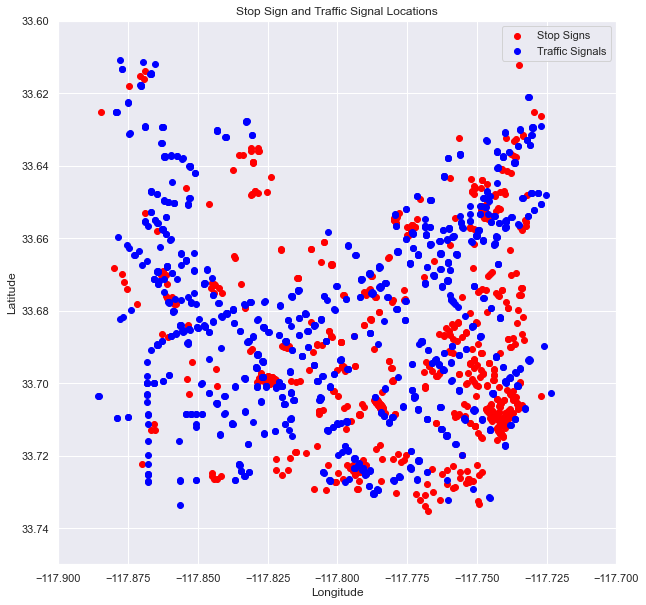

In [32]:
# Make scatter plot with axis limits and legend
plt.figure(figsize=(10,10))
plt.scatter(stop_locs['Long'], stop_locs['Lat'], c='red', label="Stop Signs")
plt.scatter(signal_locs['Long'], signal_locs['Lat'], c='blue', label="Traffic Signals")
plt.ylim(33.75, 33.6)
plt.xlim(-117.9, -117.7)
plt.legend()
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Stop Sign and Traffic Signal Locations")
plt.show()

They see to be appximately evenly distributed between the two, byt there are definitely some sections/stretches with no stop signs and a couple of high concentrations.

Let's do one more visualization. As I said earlier, we Irvine residents and visitors do like to eat. So let's take a look at the cuisine served. To be someehat ironic about it, I will use a pie chart to visualize the results.

In [33]:
#Preparing the data

cursor.execute("SELECT sum(count) FROM \
               (SELECT count(*) as count FROM nodes_tags WHERE key = 'cuisine' \
               UNION SELECT count(*) as count FROM ways_tags WHERE key = 'cuisine');")
total_cuisines = cursor.fetchone()[0]

cursor.execute("SELECT value, sum(count) as count FROM \
               (SELECT value, count(*) as count FROM nodes_tags WHERE key = 'cuisine' \
               GROUP BY value \
               UNION \
               SELECT value, count(*) as count FROM ways_tags WHERE key = 'cuisine' \
               GROUP BY value) \
               GROUP BY value ORDER BY count desc LIMIT 10;")
rows = cursor.fetchall()
cuisines = pd.DataFrame(rows, columns=['Cuisine', 'Count'])

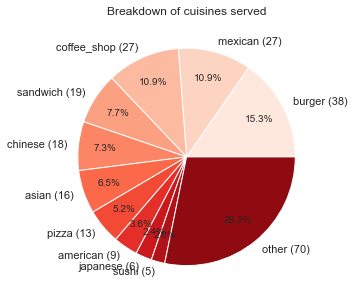

In [34]:
# Make the pie chart

values = list(cuisines['Count']) + [(total_cuisines - sum(cuisines['Count']))]
categories = list(cuisines['Cuisine']) + ['other']
labels = make_labels(categories,values)
colors=sns.color_palette("Reds",11)
plt.figure(figsize=(5, 5))
patches, texts, autotexts = plt.pie(values, labels=labels, colors=colors, \
                                    autopct=make_autopct(values), pctdistance=0.75)
for i in range(0,len(autotexts)):
    autotexts[i].set_fontsize(10)
plt.title("Breakdown of cuisines served")
plt.show()

In [35]:
#Close database connection - Keep these after any queries

conn.commit()
conn.close()

<h1>Other Thoughts About the Data</h1>



In looking at the top 10 contributors, I would like to know more about the top one, and why they have contributed so much. Unfortunately, that data is not available. I could probably getr some clues if I were to analyze what their specific contributions were, but that is beyond the scope I have chosen for this project.

Looking at the stop signs vs. traffic signals visualization, I would like to overlay that onto a map sometime and see exactly where these are.

There is clearly some additional data cleaning that needs to be done to make this data set truly useful--the religion example above illustrates this well.

<h1>Benefits & Problems of Implementing Changes</h1>

<strong>Benefits:</strong>
<ul>
<li>
    One of the greatest and most obvious benefits of implementing data wrangling changes is that it makes the data more useful. Clean, consistent data can be used for analysis to gain insights, make decisions, and take action. 
</li>
<li>
    A less obvious but still important benfit of implenting these changes is that it provides a good example for future contributors. When I am doing something new, I like to see if there are standards in place and see how others have implemented those standards. I know that not everyone is like me, but for those who are, the more clean and consistent data there is, the more they have to follow to keep their entries in line with the "good data" that's already there, thus increasing the amount of "good data." 
</li>
</ul>

<strong>Anticipated Problems:</strong>
<ul>
<li>
    The biggest anticipated problem I see with attempting to implement these changes is that for several of the tags--street names comes to mind right away--there are a lot of edge cases. Trying to deal logically, consistently, and accurately with those could be even more time consuming and challenging than usual.
</li>
<li>
    Another problem with implementing these changes, especially if they were to become data quality standards, is that they may be too restrictive to be flexible enough to accommodate all od the possible legitimate variations on the data that could belong to each tag. If they are too restrictive, they may discourage users from contributing due to frustration. But if they are not restrictive enough, then data quality remains an issue and we may be no better off than we were before we started.
</li>
</ul>

<h1>Conclusion</h1>

This data set was generally in good shape--except for the notable exceptions called out earlier. It did present some unique challenges, particularly in the street names. Even in the partially cleaned conditions for this project, it did yield some interesting insights.

I would need considerably more skill and experience to deal with some of these problems, and until I can, I would say these improvements I have identified are not ready to be implemented. Perehaps the most useful change would be to more thoroghly parse compound k-values throughout the data set. While this would take a lot more time, it may be the change that would provide the most useful changes for the time spent and could make other issues easier to identify and correct.